In [1]:
import aduq.pyam2 as am2
import os 
import numpy as np

data_path = "aduq/pyam2/data/"

feed = am2.IO.load_dig_feed(os.path.join(data_path, "influent_state.csv"))[::24][:100]
ini_state = am2.IO.load_dig_state(os.path.join(data_path, 'init_state.json'))

param = am2.IO.load_dig_param(os.path.join(data_path, "parameter.json"))

AM2 manipulates np.ndarray objects, which can be seen as pandas object using the appropriate functions.

In [2]:
print(f"Digester feed:\n{am2.IO.feed_to_pd(feed)}")

print(f"Digester State:\n{am2.IO.state_to_pd(ini_state)}")
print(f"Digester Parameter:\n{am2.IO.param_to_pd(param)}")

Digester feed:
     time         D         S1        S2         Z          C        pH
0    0.00  0.196547  30.589860  0.036125  0.036136  43.913890  7.393249
1    0.25  0.194493  30.449267  0.036252  0.036262  44.153165  7.394750
2    0.50  0.192568  30.336022  0.036386  0.036396  44.354446  7.396142
3    0.75  0.190783  30.252365  0.036526  0.036537  44.513670  7.397420
4    1.00  0.189144  30.200050  0.036671  0.036682  44.627346  7.398585
..    ...       ...        ...       ...       ...        ...       ...
95  23.75  0.216813  31.838492  0.034776  0.034786  44.044036  7.422429
96  24.00  0.219549  32.011901  0.034869  0.034878  44.474506  7.418893
97  24.25  0.222458  32.192835  0.034968  0.034977  44.867178  7.415206
98  24.50  0.225501  32.379093  0.035072  0.035081  45.217120  7.411435
99  24.75  0.228629  32.568340  0.035180  0.035189  45.520022  7.407648

[100 rows x 7 columns]
Digester State:
X1      0.665543
X2      0.269250
S1      2.543970
S2      5.413939
Z       0.036

## Basic operations

AM2 model is called through run_am2

In [3]:
pred = am2.run_am2(param=param, influent_state=feed, initial_state=ini_state)

The derivative can be computed using the am2_derivative function. It is much more stable than the adm1 counterpart, since it computes the derivative by differentiating under the integral the ODE. As such, the derivative can be computed efficiently at the same time as the output (function am2_with_der). The derivative with respect to all the parameters is computed, then translated to the derivative with respect to the required parameters. 

Note that the derivative of $Z$ with respect to the parameters is always 0 (as is theoretically the case). In practice, $Z$ might experience variations due to the ODE solver, of small ($\leq 10^{-6}) amplitudes.

In [4]:
params_to_calib = ['mu1max', "KS1"]
am2_der = am2.am2_derivative(
    param=param,
    params_to_der=params_to_calib,
    influent_state=feed,
    initial_state=ini_state,
    log_am2=False
)

# One can assess the quality of the derivative in the following fashion
import numpy as np

param_mod = param.copy()
pred = am2.run_am2(param, feed, ini_state)
param_pd = am2.IO.param_to_pd(param_mod)
perturb = np.random.normal(0,10 ** (-5), 2)
param_pd[params_to_calib] += perturb # param_mod is modified by side effect

pred_perturb = am2.run_am2(param_mod, feed, ini_state)
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    ratios = np.array((pred_perturb - pred))[:, 1:] / np.tensordot(perturb, am2_der, (0, 0)) 

print(f"Maximum discrepancy should be small: {np.max(np.abs(ratios[:, [0, 1, 2, 3, 5, 6, 7]] - 1))}")
print(f"Column for Z outputs 0/0 ratio: {np.all(np.isnan(ratios[:, 4]))}")

Maximum discrepancy should be small: 0.15034619350683942
Column for Z outputs 0/0 ratio: True


Due to the small number of parameters, it is always assumed that all parameters are calibrated and no sensitivity analysis module is prepared.

## Optimisation routines

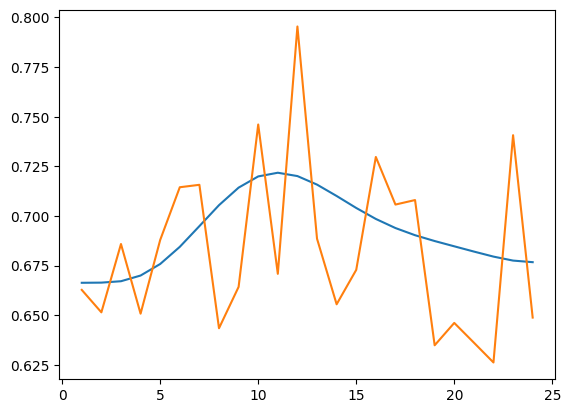

Prediction error: 0.05543222498824409


In [5]:
obs = pred.copy()
obs[:, 1:] = obs[:, 1:] * np.exp( np.random.uniform(-0.1, 0.1, obs[:, 1:].shape) )

import matplotlib.pyplot as plt
obs_pd = am2.IO.states_to_pd(obs)
pred_pd = am2.IO.states_to_pd(pred)
plt.plot(pred_pd["time"], pred_pd["X1"])
plt.plot(obs_pd["time"], obs_pd["X1"])
plt.show()
print(f"Prediction error: {am2.am2_err(pred, obs)}")

Score at step 0: 0.6817051015871542
Score at step 8: 0.3621645440378527
Score at step 16: 0.36054672268948296
Optimisation algorithm did not converge


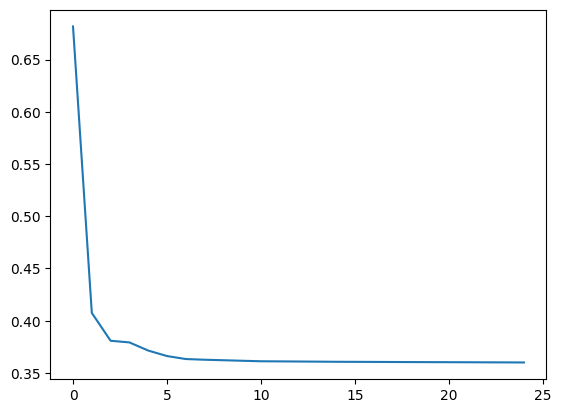

In [6]:
init_param = param.copy()
init_param = init_param  *  np.random.uniform(
    0.5, 2, len(init_param)
) 

out = am2.optim.optim_cma_am2(
    init_param=init_param,
    obs=obs,
    chain_length=24,
    influent_state=feed,
    initial_state=ini_state,
    per_step=8, 
    print_rec=8,
    radius_factor=0.8,
    radius_ini=.6
)
opti_param = out.opti_param

import matplotlib.pyplot as plt

plt.plot(out.hist_score)

In [7]:
optim_res = am2.optim.am2_vi(
    obs=obs,
    influent_state=feed,
    initial_state=ini_state,
    temperature=0.01,
    chain_length=40,
    per_step=20,
    step_size=0.01,
    gen_decay=0.05,
    momentum=0.8,
    print_rec=4,
    parallel=True,
)

Score at step 0: 0.4149502465377091 (KL: 0.0, score:0.4149502465377091)
Score at step 4: 0.3301811944752705 (KL: 0.006385981892897462, score:0.3301173346563415)
Score at step 8: 0.3530079649210609 (KL: 0.02516825499411156, score:0.3527562823711198)
Score at step 12: 0.3296725389256612 (KL: 0.05059425462137987, score:0.3291665963794474)
Score at step 16: 0.3118866931263815 (KL: 0.08176072870492569, score:0.31106908583933224)
Score at step 20: 0.29500204383695455 (KL: 0.11682254304939499, score:0.2938338184064606)
Score at step 24: 0.284217853612882 (KL: 0.15818804836760786, score:0.2826359731292059)
Score at step 28: 0.27011111278172323 (KL: 0.2073229986439978, score:0.26803788279528323)
Score at step 32: 0.2572235315897808 (KL: 0.2641810482990787, score:0.25458172110679)
Score at step 36: 0.24627415721337362 (KL: 0.3333996079207608, score:0.242940161134166)


## UQ module

### Fisher's information

In [8]:
fim_out = am2.UQ.am2_fim(opti_param, obs, feed, ini_state, silent=True)
am2.UQ.am2_fim_pval(param, opti_param, cov = fim_out["cov"], inv_cov = fim_out["fisher"] )

Noise level: 0.36001059953963155


/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/uncertainty/fim.py:63: HighConditioningNumber: Conditioning number is 1912349418139.5586 > 1000000.0.
  warnings.warn(


0.0

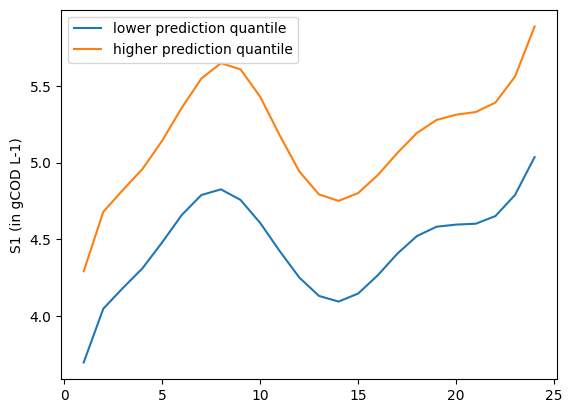

In [9]:
# And one can evaluate the uncertainty on the previsions using linear transfer of uncertainty and gaussian hypothesis

output_UQ = am2.UQ.am2_fim_pred(
    opti_predict=fim_out["opti_predict"],
    cov=fim_out["cov"],
    der_log_am2=fim_out["der_log_am2"],
    conf_lev=0.7,
)

low_quant = am2.IO.states_to_pd(output_UQ["lower_quant"])
high_quant = am2.IO.states_to_pd(output_UQ["upper_quant"])
plt.plot(low_quant["time"], low_quant["S1"], label="lower prediction quantile")
plt.plot(high_quant["time"], high_quant["S1"], label="higher prediction quantile")
plt.legend()
plt.ylabel(f"S1 (in {am2.IO.predict_units_dict['S1']})")
plt.show()

In [10]:
beale_out = am2.UQ.am2_beale(20, conf_lev=.99, cov=fim_out['cov'], param=opti_param, params_eval=params_to_calib, obs=obs,influent_state=feed, initial_state=ini_state)



Uncertainty quantification through error bound

Optimal parameter:
mu1max    0.740233
KS1       8.555125
dtype: float64
Parameter covariance:
          mu1max        KS1
mu1max  0.162304   2.081701
KS1     2.081701  27.049430
Parameter covariance in log space:
          mu1max       KS1
mu1max  0.296205  0.328718
KS1     0.328718  0.369577
Standard deviation in log space: [0.54424736 0.60792878]
Calling beale_boundary function.
Confidence region boundary is computed in log-parameters space.
Optimal parameter in this space is:
[-0.30079084  2.14653051]
Covariance is:
          mu1max       KS1
mu1max  0.296205  0.328718
KS1     0.328718  0.369577

Confidence level: 0.99
Points on the boundary: 20
Number of observation points:96
------------------
Threshold score is: 0.1429498698483662, while min score is: 0.1296076310723164.
The ratio is 1.1029433117916128
Starting iteration 1Starting iteration 2Starting iteration 3Starting iteration 4Starting iteration 5

Starting iteration 6
Startin

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


Iteration succeeded
Iteration succeededParameter in log space: [-0.20473235  2.28720578]

Parameter in log space: [-0.72577511  1.62232475]Starting iteration 13

Starting iteration 14
Iteration succeeded
Parameter in log space: [-0.69015782  1.67738777]
Starting iteration 15
Iteration succeeded
Parameter in log space: [-0.04189252  2.44981633]
Starting iteration 16
Step failed: Could not compute error for parameter:
[4.71810338e-03 8.39749694e-01 7.46712290e-02 8.41887927e+00
 1.46684291e+02]

invalid value encountered in log
Starting iteration 17
Iteration succeeded
Parameter in log space: [-0.0472019   2.44479623]
Iteration succeededStarting iteration 18

Parameter in log space: [-0.79123453  1.51590278]
Starting iteration 19
Iteration succeeded
Parameter in log space: [0.20990431 2.67121818]
Starting iteration 20
Iteration succeeded
Parameter in log space: [-0.19335738  2.29931305]
Iteration succeeded
Parameter in log space: [-0.34701571  2.13039439]
Iteration succeeded
Parameter in

/Users/apicard/Documents/Suez/Git/ADUncertaintyQuantification/aduq/uncertainty/beale.py:248: UserWarning: 2/20 line searches procedure failed.
  warnings.warn(f"{n_failed}/{n_boundary} line searches procedure failed.")


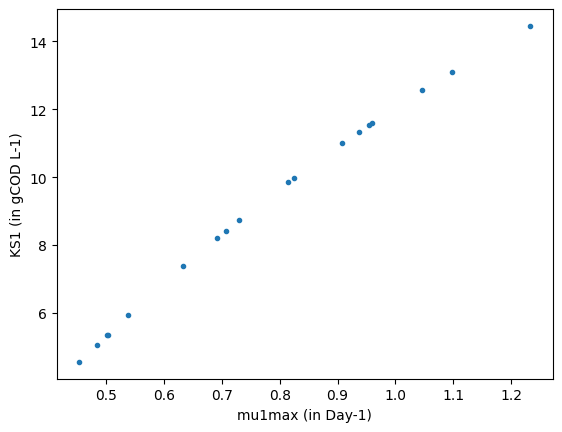

In [11]:
plt.plot(beale_out["boundary"]["mu1max"], beale_out["boundary"]["KS1"], ".")
plt.xlabel(f"mu1max (in {am2.IO.parameter_units['mu1max']})")
plt.ylabel(f"KS1 (in {am2.IO.parameter_units['KS1']})")
plt.show()

In [12]:
from aduq.pyam2.UQ.bootstrap import am2_lin_bootstrap
lin_boot_out = am2_lin_bootstrap(10**4, obs=obs, opti_param=opti_param, params_eval=params_to_calib, influent_state=feed, initial_state=ini_state)

Starting linear bootstrap procedure
Computing output of AM2 model
Computing gradient of AM2 model
Generating the bootstrapped samples


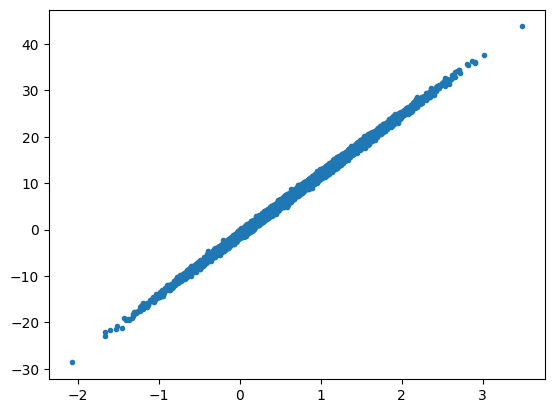

In [13]:
import pandas as pd
sample_boot = lin_boot_out["sample"]
sample_pd = pd.DataFrame(sample_boot, columns = list(am2.IO.parameter_dict.keys()))
plt.plot(sample_pd["mu1max"], sample_pd["KS1"], '.')

In [14]:
boot_out = am2.UQ.am2_bootstrap(
    20,
    opti_param =opti_param, obs=obs,
    influent_state=feed, initial_state=ini_state,
    chain_length=8, per_step=20, radius_ini=.1)

Starting bootstrapped calibration 1
Starting bootstrapped calibration 2
Starting bootstrapped calibration 3
Starting bootstrapped calibration 4
Starting bootstrapped calibration 7Starting bootstrapped calibration 5Starting bootstrapped calibration 6
Starting bootstrapped calibration 8


Score at step 0: 0.36419780629769505
Score at step 0: 0.3518160545452247
Score at step 0: 0.35269056499093404
Score at step 0: 0.35716344987859894
Score at step 0: 0.34963912758407006
Score at step 0: 0.35458435878928923Score at step 0: 0.3633013240840565

Score at step 0: 0.3583434316292781
Score at step 5: 0.12384007615302958
Score at step 5: 0.10664945962788096
Score at step 5: 0.19756399211345235
Score at step 5: 0.12300191619622924
Score at step 5: 0.27086769695627655
Score at step 5: 0.14183590549480704
Score at step 5: 0.1384102963804003
Score at step 5: 0.21676394626237294
Optimisation algorithm did not converge
Starting bootstrapped calibration 9
Score at step 0: 0.3586626317275662
Optimisation

In [15]:
sample_full_boot_pd = pd.DataFrame(np.array(boot_out), columns = list(am2.IO.parameter_dict.keys()))

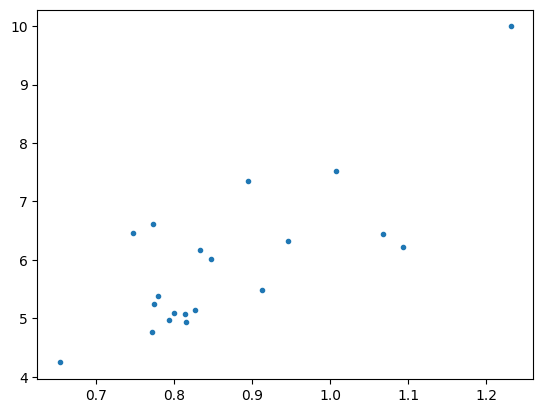

In [16]:
plt.plot(sample_full_boot_pd["mu1max"], sample_full_boot_pd["KS1"], '.')